## Section 1 - Exploratory Data Analysis and Time Series Decomposition

The data I'm working with shows the prices of lumber over time, and it comes from a trustworthy source called the "U.S. Bureau of Labor Statistics." The Data is collected and aggregated at monthly level from 1947 Jan to 2023 Nov. Lumber prices can go up or down because of various reasons, like how much people want to buy it, how much is available, how the economy is doing, and how much construction is happening. Changes in lumber prices might follow a pattern, such as higher demand during construction-heavy times, and they can also be affected by broader economic factors. Other things like weather, how forests are managed, and trade disagreements can also play a role. Predicting lumber prices is tricky because it depends on many factors, and the market is always changing. The lumber industry is influenced by a mix of economic, environmental, and global factors, making it complex to predict prices accurately for both the short term and long term.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import date2num

import seaborn as sns
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from scipy.stats import boxcox
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy


import logging
from cmdstanpy import CmdStanModel

logging.getLogger('cmdstanpy').setLevel(logging.WARNING)


In [43]:
data = pd.read_csv("lumber_price.csv")
data['date'] = pd.to_datetime(data['date'])

In [44]:
summary = data['lumber_price'].describe()
summary['median'] = data['lumber_price'].median()
summary_df = pd.DataFrame(summary)
summary_df.index.name = "summary_stats"
summary_df.reset_index()

,summary_stats,lumber_price
0,count,923.000000
1,mean,120.875394
2,std,86.519930
3,min,19.800000
4,25%,30.900000
5,50%,113.200000
6,75%,181.700000
7,max,581.500000
8,median,113.200000


The minimum and maximum values indicate a range from 19.8 to 581.5, showcasing the variability in lumber prices over time.


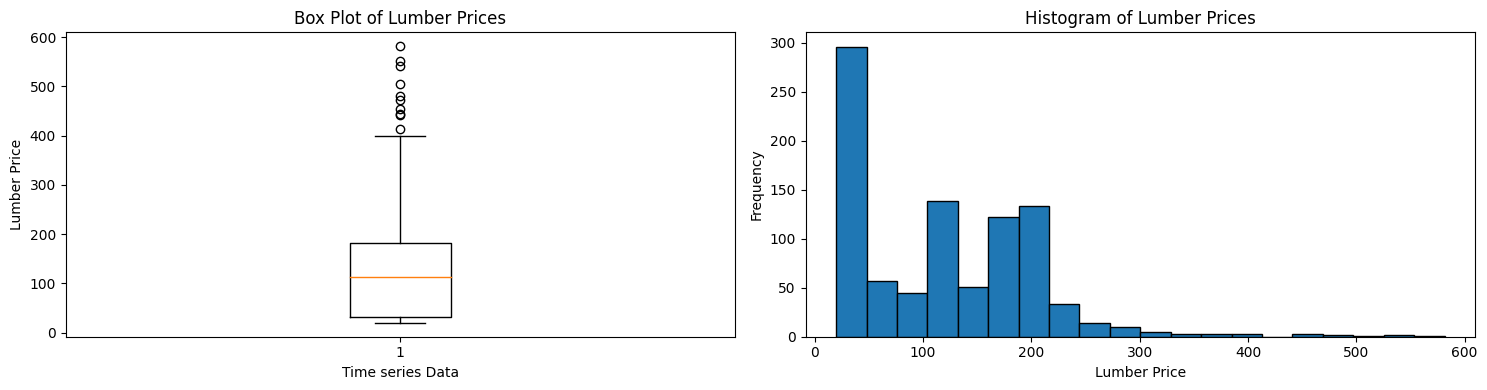

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].boxplot(data['lumber_price'])
axes[0].set_xlabel("Time series Data")
axes[0].set_ylabel("Lumber Price")
axes[0].set_title("Box Plot of Lumber Prices")

axes[1].hist(data['lumber_price'], bins=20, edgecolor='black')
axes[1].set_xlabel("Lumber Price")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of Lumber Prices")

plt.tight_layout()
plt.show()


1. The box plot reveals the presence of outliers in the dataset.
2. The histogram illustrates a rightward skewness in the data distribution.

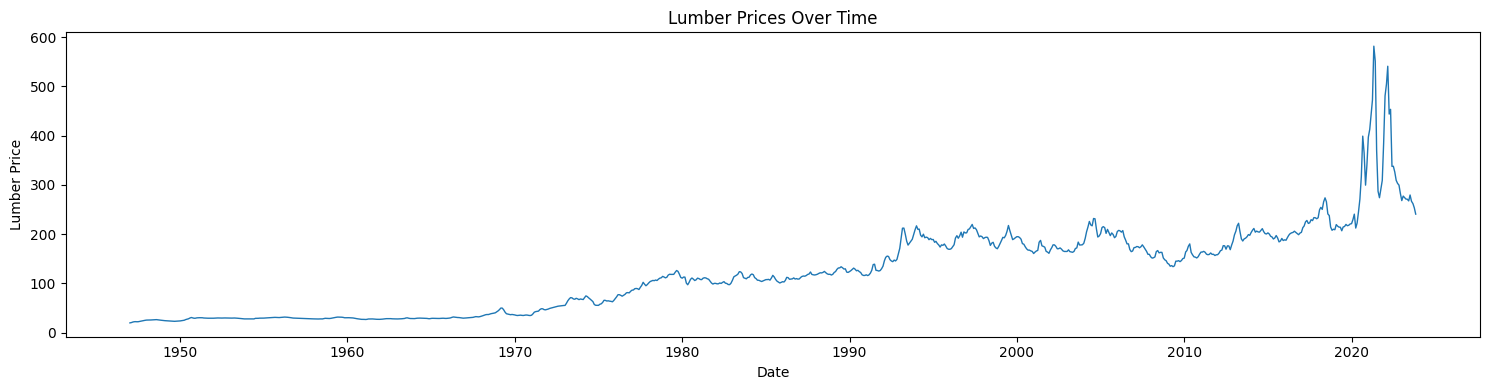

In [46]:
plt.figure(figsize=(15, 4))
sns.lineplot(x='date', y='lumber_price', data=data, linewidth = 1)
plt.title('Lumber Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Lumber Price')
plt.tight_layout()

plt.show()

1. The line chart indicates a lack of discernible trend in the data until 1970. Subsequently, there is a noticeable upward trend from 1970 onward. 
2. However, post-2020, the data exhibits a considerable amount of noise, suggesting increased variability or fluctuations without a clear, consistent direction.

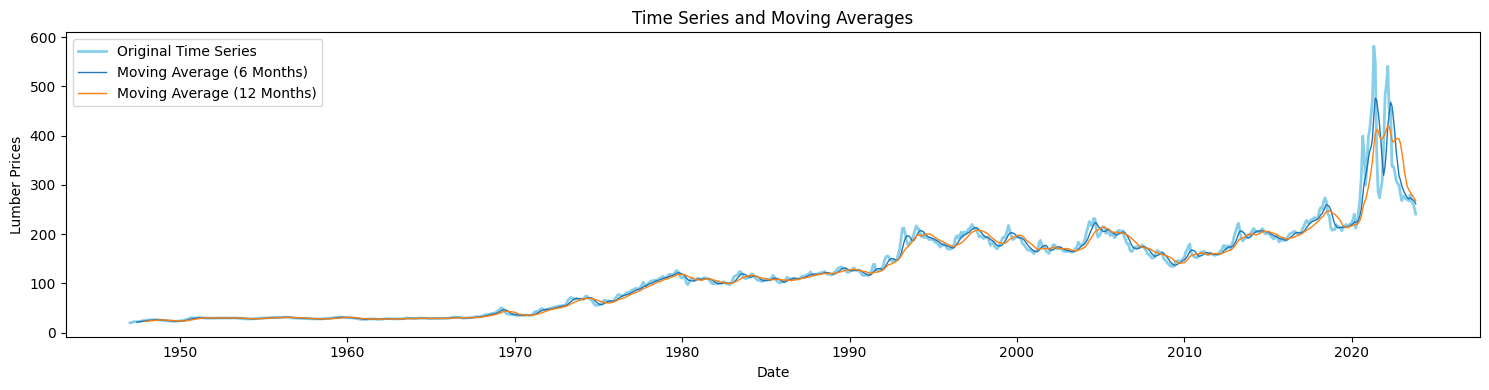

In [47]:
plt.figure(figsize=(15, 4))

window_sizes = [6,12]
plt.plot(data['date'], data['lumber_price'], label='Original Time Series', linewidth=2, color = 'skyblue')

for window_size in window_sizes :
    
    moving_average = data['lumber_price'].rolling(window=window_size).mean()
    plt.plot(data['date'], moving_average, label=f'Moving Average ({window_size} Months)', linewidth=1, linestyle = "-")

    plt.title('Time Series and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Lumber Prices')
plt.legend()
plt.tight_layout()
plt.show()

1. The 12-month Moving Average curve noticeably smoothens the original data curve, capturing both peaks and valleys effectively.
2. Given the monthly nature of the data, the analysis is conducted using a 12-month Window for optimal results.

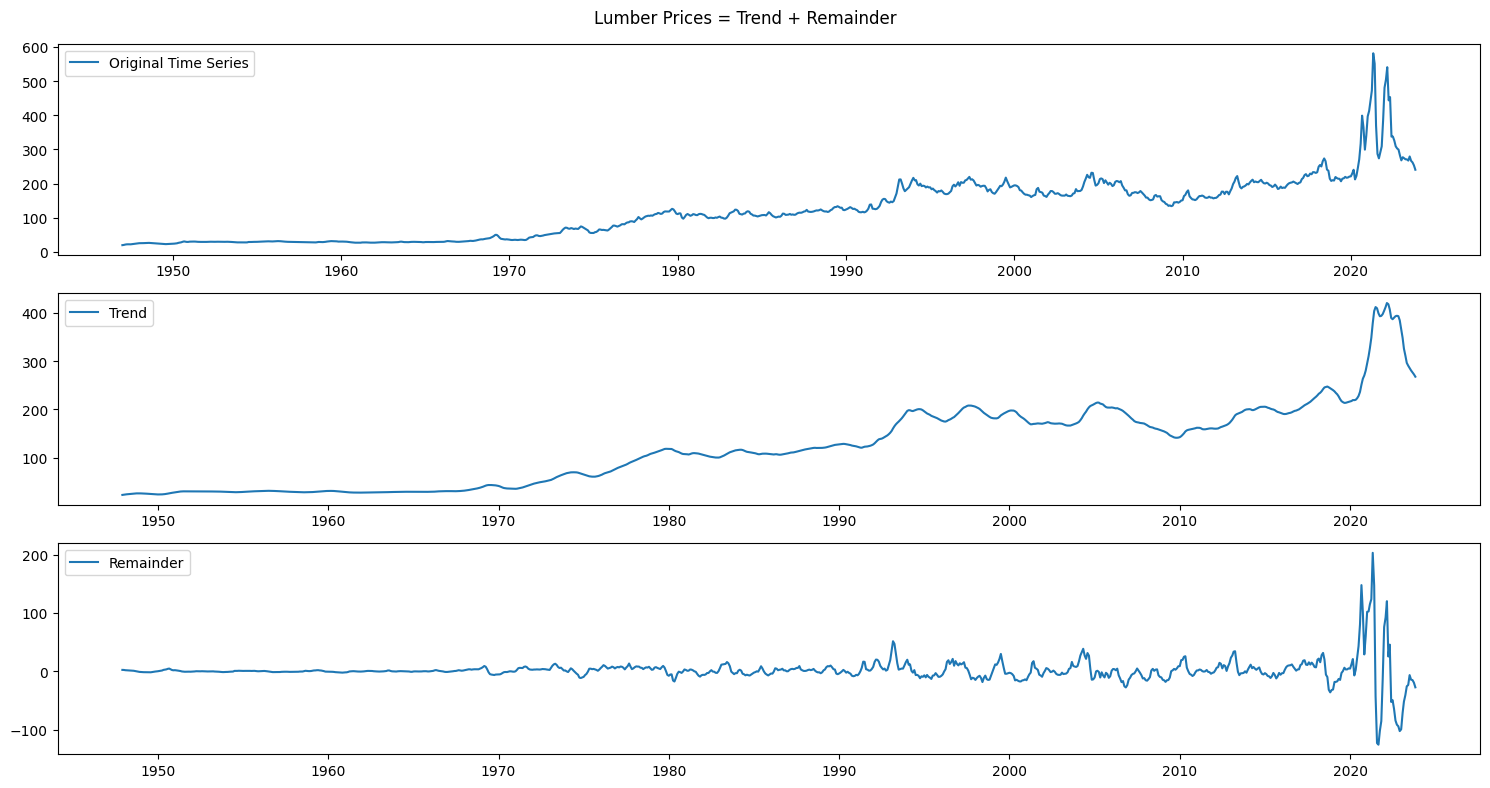

In [48]:
data['ma_12'] = moving_average
data['remainder'] = data['lumber_price'] - data['ma_12']

plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['lumber_price'], label='Original Time Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data['date'], data["ma_12"], label='Trend')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(data['date'], data["remainder"], label='Remainder')
plt.legend()

plt.suptitle("Lumber Prices = Trend + Remainder")
plt.tight_layout()
plt.show()


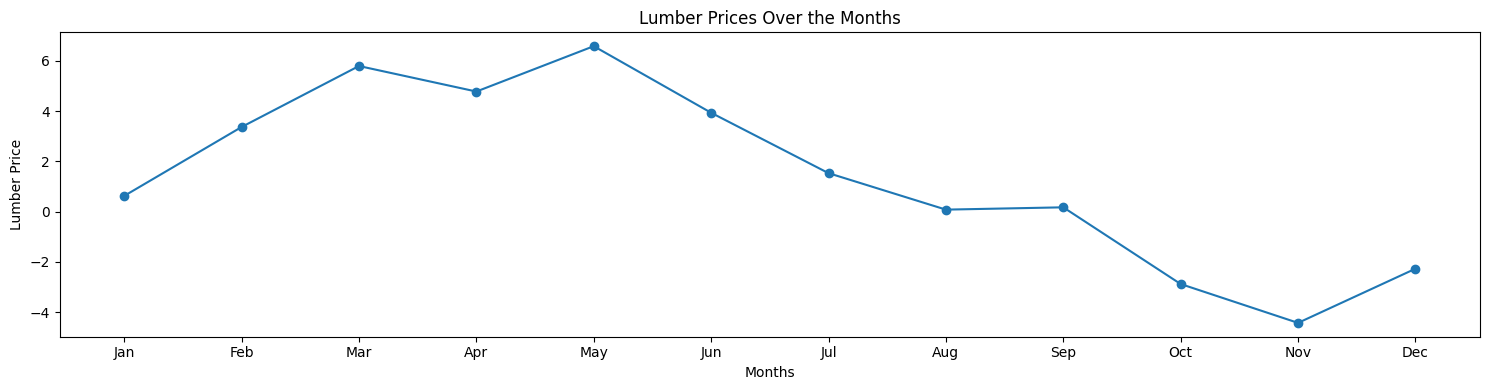

In [49]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.strftime('%b')
dd = data.groupby(['month']).agg({'remainder':'mean'}).reset_index()
dd['month'] = pd.Categorical(dd['month'], categories=pd.date_range('2000-01-01', periods=12, freq='MS').strftime('%b'), ordered=True)
dd = dd.sort_values('month')

plt.figure(figsize=(15, 4))
plt.plot(dd['month'], dd['remainder'], marker='o')
plt.xlabel("Months")
plt.ylabel("Lumber Price")
plt.title("Lumber Prices Over the Months")
plt.tight_layout()
plt.show()

The pattern in the leftover values shows a seasonal trend, with lumber prices being high in May and lower in November and December. Hence, it makes sense to extract and examine the seasonality in the data.

In [50]:
data['month'] = data['date'].dt.month
seasonal_mean = data.groupby(['month'])['remainder'].mean()
data['seasonal'] = data.month.map(seasonal_mean)
data['residual'] = data['remainder'] - data['seasonal']

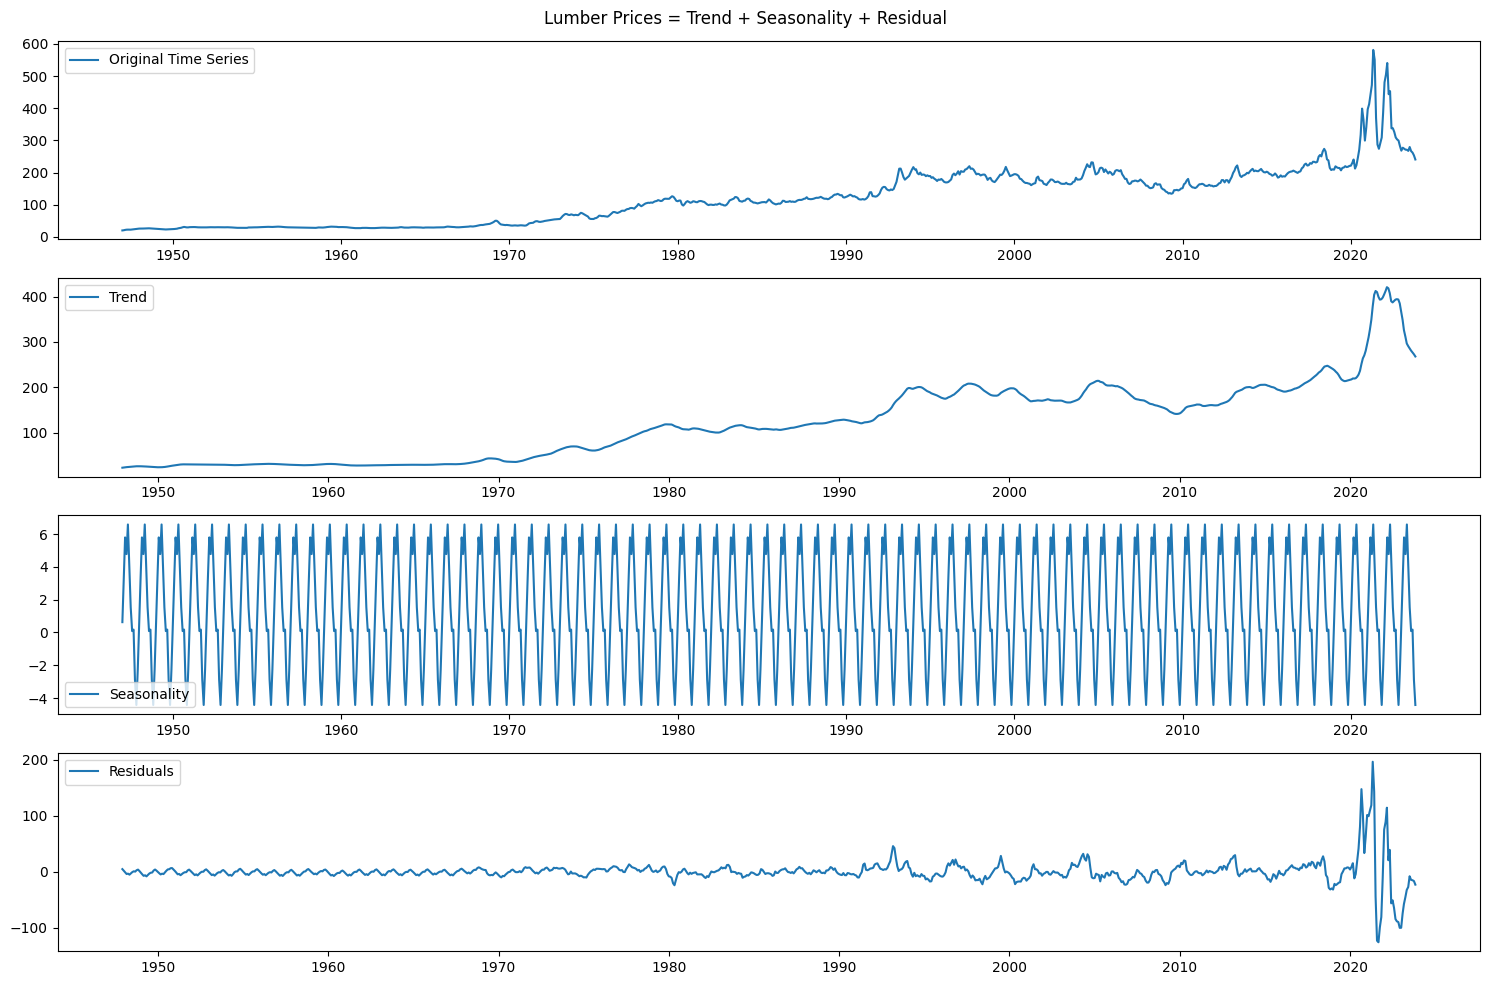

In [51]:
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.plot(data['date'], data['lumber_price'], label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(data['date'], data["ma_12"], label='Trend')
plt.legend()


plt.subplot(4, 1, 3)
plt.plot(data['date'], data["seasonal"], label='Seasonality')
plt.legend()


plt.subplot(4, 1, 4)
plt.plot(data['date'], data["residual"], label='Residuals')
plt.legend()

plt.suptitle("Lumber Prices = Trend + Seasonality + Residual")
plt.tight_layout()
plt.show()

In [52]:
train_size_perc = 90
train_indices = int((data.shape[0] * 90)/100)

train_data = data.loc[:train_indices]
test_data = data.loc[train_indices+1:]

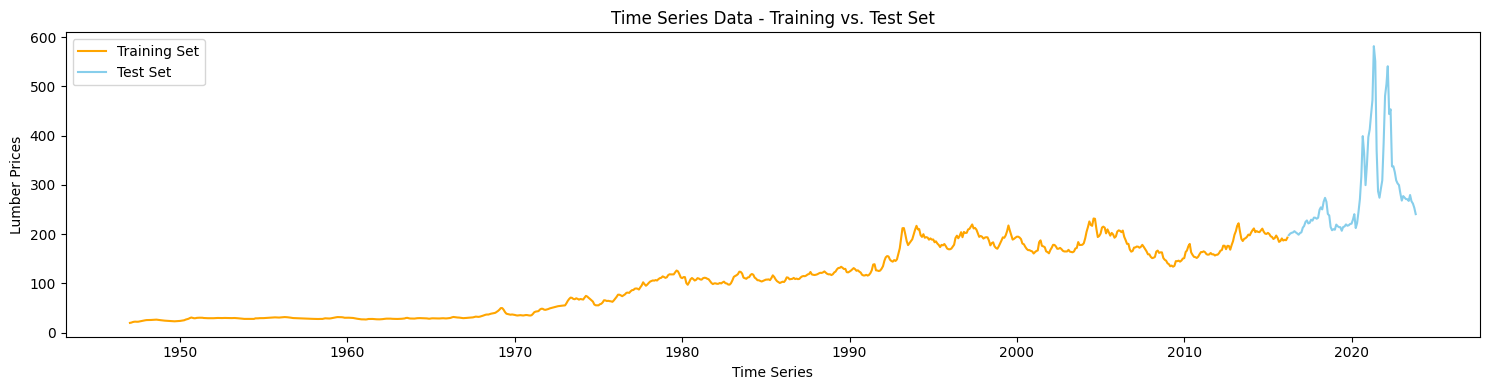

In [53]:
plt.figure(figsize=(15, 4))


plt.plot(train_data['date'], train_data['lumber_price'], label='Training Set', color='orange')
plt.plot(test_data['date'], test_data['lumber_price'], label='Test Set', color='skyblue')

plt.xlabel('Time Series')
plt.ylabel('Lumber Prices')
plt.title('Time Series Data - Training vs. Test Set')
plt.legend()

plt.tight_layout()
plt.show()


## Section 2 - ARIMA Modeling

#### Stationarity Assesment

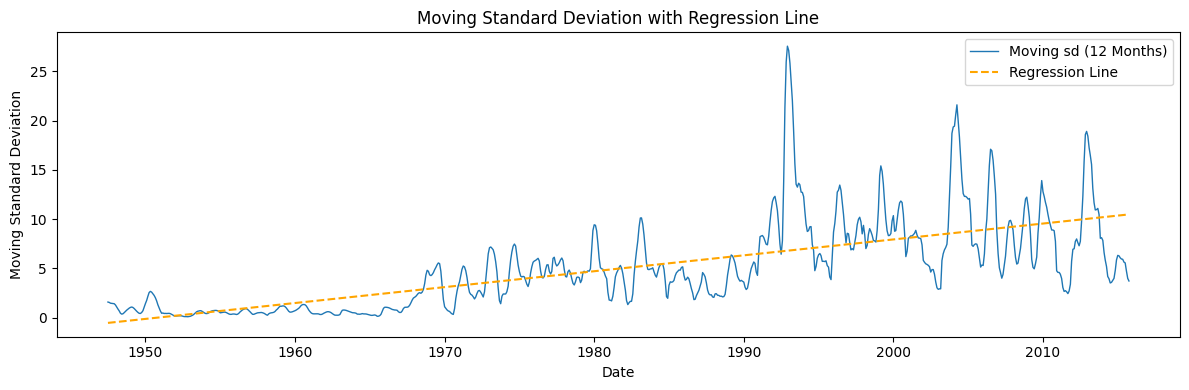

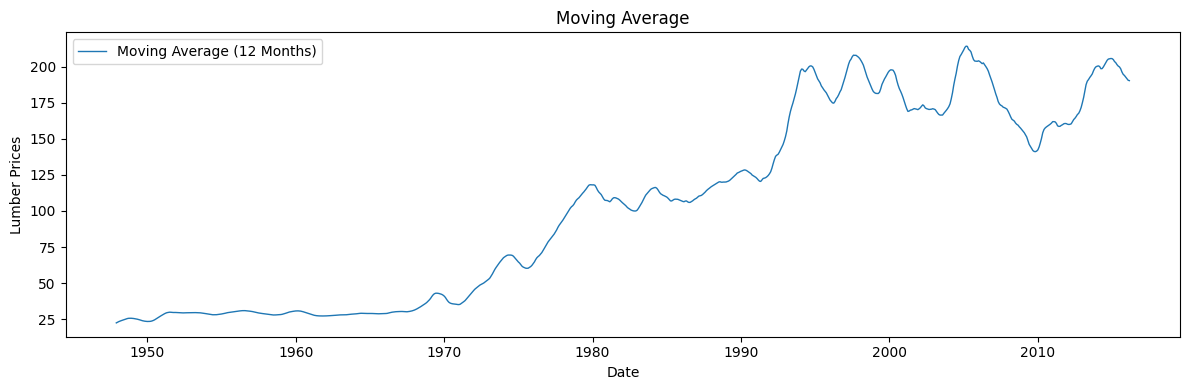

In [54]:

moving_sd = train_data['lumber_price'].rolling(window=12, center=True).std().dropna()
indices = moving_sd.index
aligned_dates = train_data['date'][indices]

plt.figure(figsize=(12, 4))
plt.plot(aligned_dates, moving_sd, label=f'Moving sd ({12} Months)', linewidth=1)
coefficients = np.polyfit(indices, moving_sd.values, 1)
linear_regression = np.polyval(coefficients, indices)
plt.plot(aligned_dates, linear_regression, label='Regression Line', linestyle='--', color='orange')
plt.legend()
plt.title('Moving Standard Deviation with Regression Line')
plt.xlabel('Date')
plt.ylabel('Moving Standard Deviation')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(train_data['date'], train_data['ma_12'], label=f'Moving Average ({window_size} Months)', linewidth=1, linestyle="-")
plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Lumber Prices')
plt.legend()
plt.tight_layout()
plt.show()


From the above plots:
1. Its evident that the average (mean) of Lumber Prices doesnt remain steady over the years from 1970 to 2020.
2. Additionally, the fluctuations in prices show a pattern that isn't consistent, indicating that the variability (variance) is not constant throughout the time period.
3. The moving average plot indicates an upward trend in lumber prices, suggesting that the prices do not exhibit mean stationarity.
4. Therefore, Lumber Prices data is neither mean stationary nor varaince stationary

#### Log and Box Cox Transformations

In [55]:
train_data['log_lumber_price'] = np.log(train_data['lumber_price'])
train_data['box_cox_lumber_price'],_ = boxcox(train_data['lumber_price'])

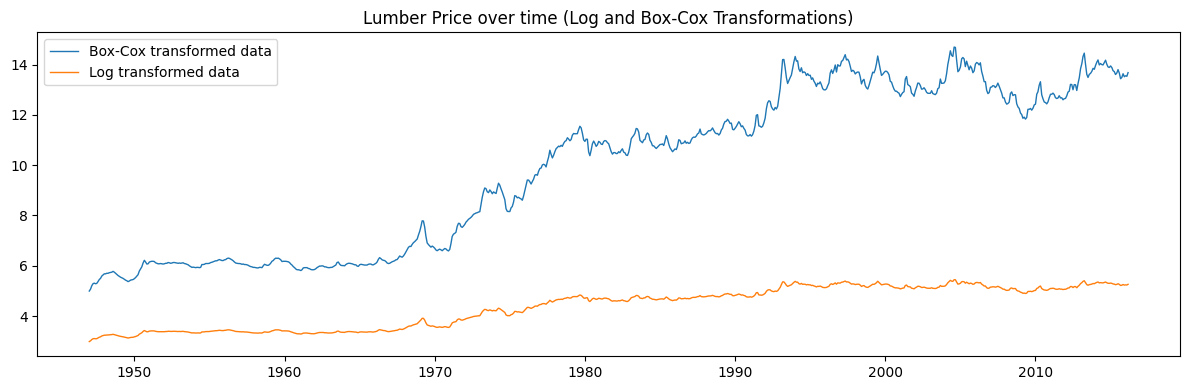

In [56]:
plt.figure(figsize=(12, 4))

plt.plot(train_data['date'], train_data['box_cox_lumber_price'], label='Box-Cox transformed data', linewidth=1)
plt.plot(train_data['date'], train_data['log_lumber_price'], label='Log transformed data', linewidth=1)

plt.legend()
plt.title("Lumber Price over time (Log and Box-Cox Transformations)")
plt.tight_layout()
plt.show()

Log reduces variance effectively more than Box Cox transformation so we will be proceeding with log transformed data for the furthur analysis

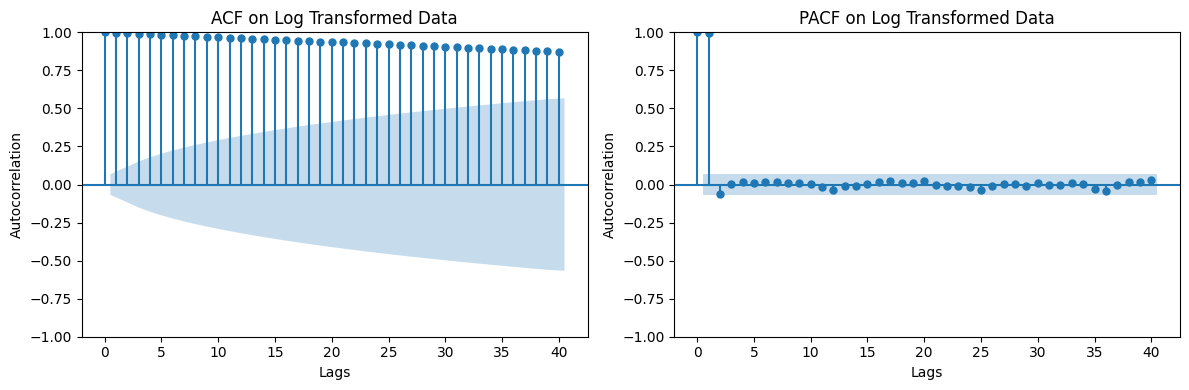

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(train_data['log_lumber_price'].dropna(), lags=40, title='ACF on Log Transformed Data', ax=ax1)
plot_pacf(train_data['log_lumber_price'].dropna(), lags=40, title='PACF on Log Transformed Data', ax=ax2)

ax1.set(xlabel="Lags", ylabel="Autocorrelation")
ax2.set(xlabel="Lags", ylabel="Autocorrelation")

plt.tight_layout()
plt.show()

There is no seasonality on log transformed data.
Consequently, the next step involves checking mean stationarity

#### KPSS Test for mean stationarity

In [58]:
lag_value = -1
p_value = 0
while p_value < 0.05:
    lag_value += 1
    
    if lag_value:
        lagged_data = train_data['log_lumber_price'].diff().dropna()
    else:
        lagged_data = train_data['log_lumber_price'].dropna()
        
    kpss_stat, p_value, _, _ = kpss(lagged_data)
    
    if p_value < 0.05:
        print(f"Data is not mean stationary at lag difference : {lag_value} and p_value : {p_value}")
    else:
        print(f"Data is mean stationary at lag difference : {lag_value} and p_value : {p_value}")

Data is not mean stationary at lag difference : 0 and p_value : 0.01
Data is mean stationary at lag difference : 1 and p_value : 0.1


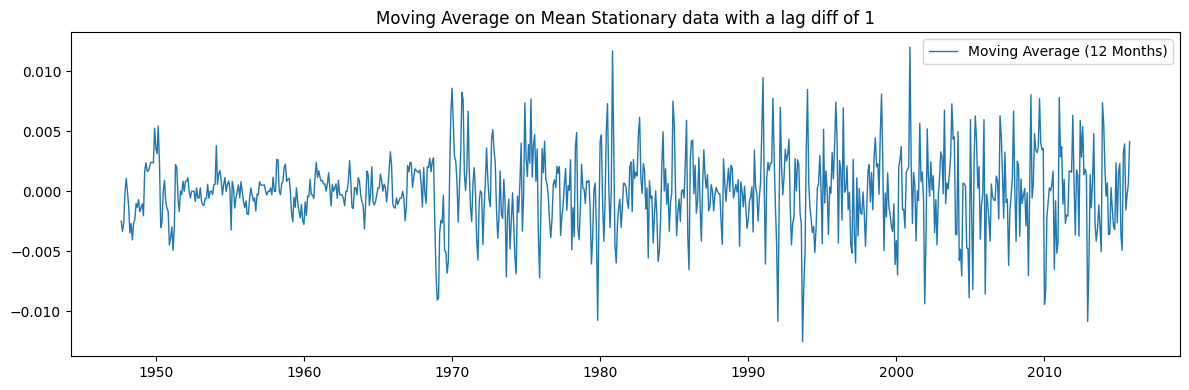

In [59]:
months = 12

train_data['transformed_data'] = train_data['log_lumber_price'].diff()
moving_average = train_data['transformed_data'].diff().rolling(window = months, center=True).mean()

plt.figure(figsize=(12, 4))

plt.plot(train_data['date'], moving_average, label=f'Moving Average ({months} Months)', linewidth=1)
plt.legend()
plt.title(f"Moving Average on Mean Stationary data with a lag diff of {lag_value}")
plt.tight_layout()
plt.show()

The visual inspection indicates that our data is mean stationary. 
Consequently, for our ARIMA model, we determine that d=1

#### ACF/PACF plots on stationary data

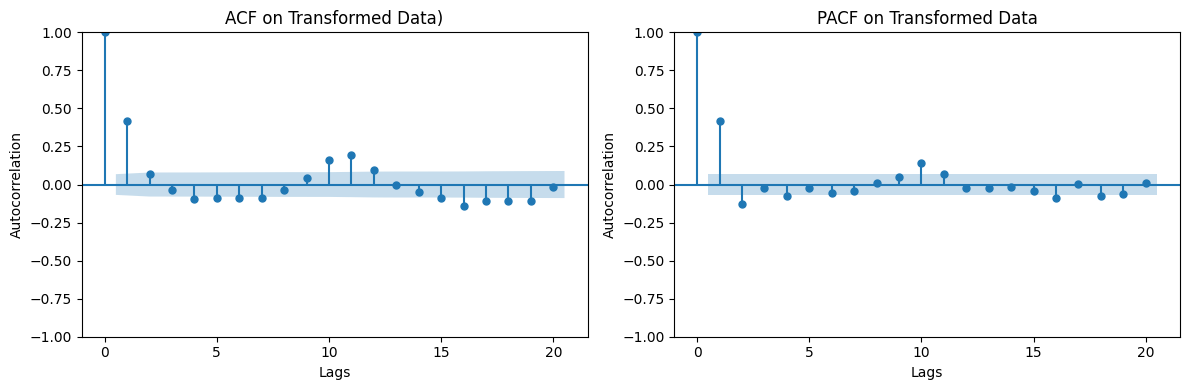

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(train_data['transformed_data'].dropna(), lags=20, title='ACF on Transformed Data)', ax=ax1)
plot_pacf(train_data['transformed_data'].dropna(), lags=20, title='PACF on Transformed Data', ax=ax2)

ax1.set(xlabel="Lags", ylabel="Autocorrelation")
ax2.set(xlabel="Lags", ylabel="Autocorrelation")

plt.tight_layout()
plt.show()

1. There is a dampening effect in ACF plot indication only AR process
2. Its AR(2) and d = 1 and MA(0) so ARIMA(2,1,0)
3. The current analysis indicates an absence of seasonality. Nevertheless, we can employ the Ljung-Box test to assess whether any seasonality persists in our residuals.

#### ARIMA Modeling

In [61]:
model1 = ARIMA(train_data['log_lumber_price'].dropna(), order=(2,1,0), seasonal_order=(0, 0, 0, 0)).fit()
model2 = ARIMA(train_data['log_lumber_price'].dropna(), order=(2,1,1), seasonal_order=(0, 0, 0, 0)).fit()
model3 = ARIMA(train_data['log_lumber_price'].dropna(), order=(2,1,2), seasonal_order=(0, 0, 0, 0)).fit()

In [62]:
model_list = [model1, model2, model3]
order_list = [(2,1,0), (2,1,1),(2,1,2)]
aic_df = pd.DataFrame(columns = ["Model_Name","AIC", "Order"])


for ind, model in enumerate(model_list):

    model_name = "model" + str(ind+1)
    
    aic = model.aic
    
    aic_df.loc[len(aic_df)] = [model_name, aic, order_list[ind]]

aic_df.set_index('Model_Name',inplace=True)
aic_df.sort_values(by = 'AIC', ascending=True)

,AIC,Order
Model_Name,,
model1,-3767.455891,"(2, 1, 0)"
model2,-3766.138507,"(2, 1, 1)"
model3,-3764.094510,"(2, 1, 2)"


Model1 : ARIMA(2,1,0) has the lowest AIC value compared to the rest.

#### Ljung-Box for residual analysis

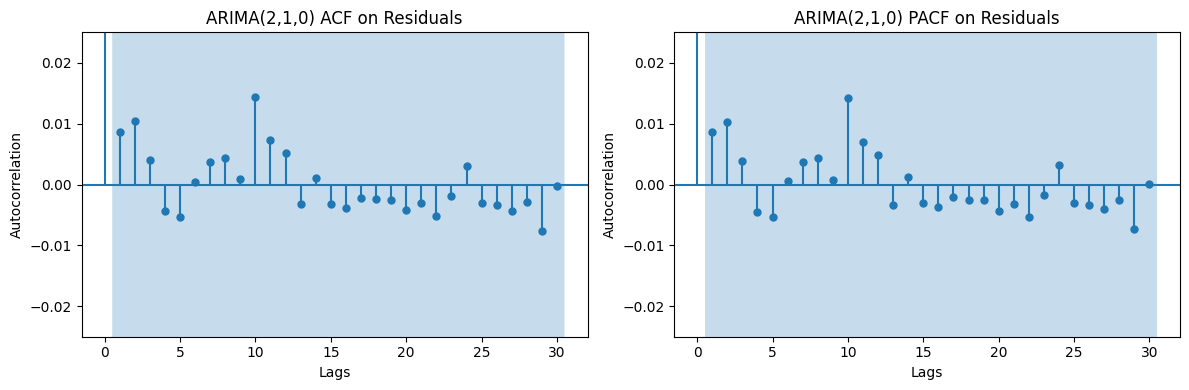

In [63]:
resid = model1.resid

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(resid, lags=30, title='ARIMA(2,1,0) ACF on Residuals', ax=ax1)
plot_pacf(resid, lags=30, title='ARIMA(2,1,0) PACF on Residuals', ax=ax2)

ax1.set(xlabel="Lags", ylabel="Autocorrelation")
ax2.set(xlabel="Lags", ylabel="Autocorrelation")
ax1.set_ylim([-0.025,0.025])
ax2.set_ylim([-0.025,0.025])



plt.tight_layout()
plt.show()


In [64]:
df_stats = sm.stats.acorr_ljungbox(resid, lags=12)
df_stats

,lb_stat,lb_pvalue
1,0.062051,0.803284
2,0.151600,0.927002
3,0.164882,0.983049
4,0.180770,0.996153
5,0.204006,0.999070
6,0.204139,0.999836
7,0.215192,0.999968
8,0.231183,0.999993
9,0.232002,0.999999
10,0.406615,0.999998


For Box-Ljung test, p_value > 0.05 for all lags indicating no autocorrelation at that lag.
So our residuals are nothing but white noise

Let's compare the original time series data with the time series data fitted using the ARIMA model.


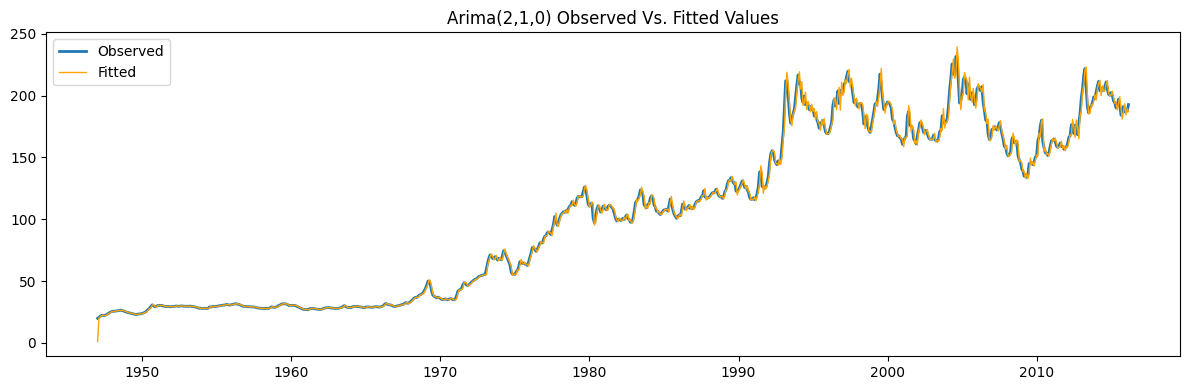

In [65]:
fitted_values_arima = model1.fittedvalues

plt.figure(figsize=(12, 4))
plt.plot(train_data['date'], train_data['lumber_price'], label='Observed', linewidth=2)
plt.plot(train_data['date'], np.exp(fitted_values_arima), label='Fitted', color='orange',linewidth = 1)
plt.title('Arima(2,1,0) Observed Vs. Fitted Values')
plt.tight_layout()
plt.legend()
plt.show()

The in-sample predicted values (fitted values) tend to follow the trends in the original data which implies our our ARIMA model is capturing the underlying patterns in the time series. This indicates that our model is providing a good fit to the historical data.

## Section 3 - Meta Prophet Model

In [66]:
prophet_data = train_data.rename(columns={'date':'ds',
                                           'lumber_price':'y'})


model = Prophet()
model.fit(prophet_data)
forecast = model.predict(prophet_data)

trend = forecast['trend']
multiplicative_seasonality = forecast['multiplicative_terms']
additive_seasonality = forecast['additive_terms']
residual = forecast['yhat'] -  prophet_data['y']  

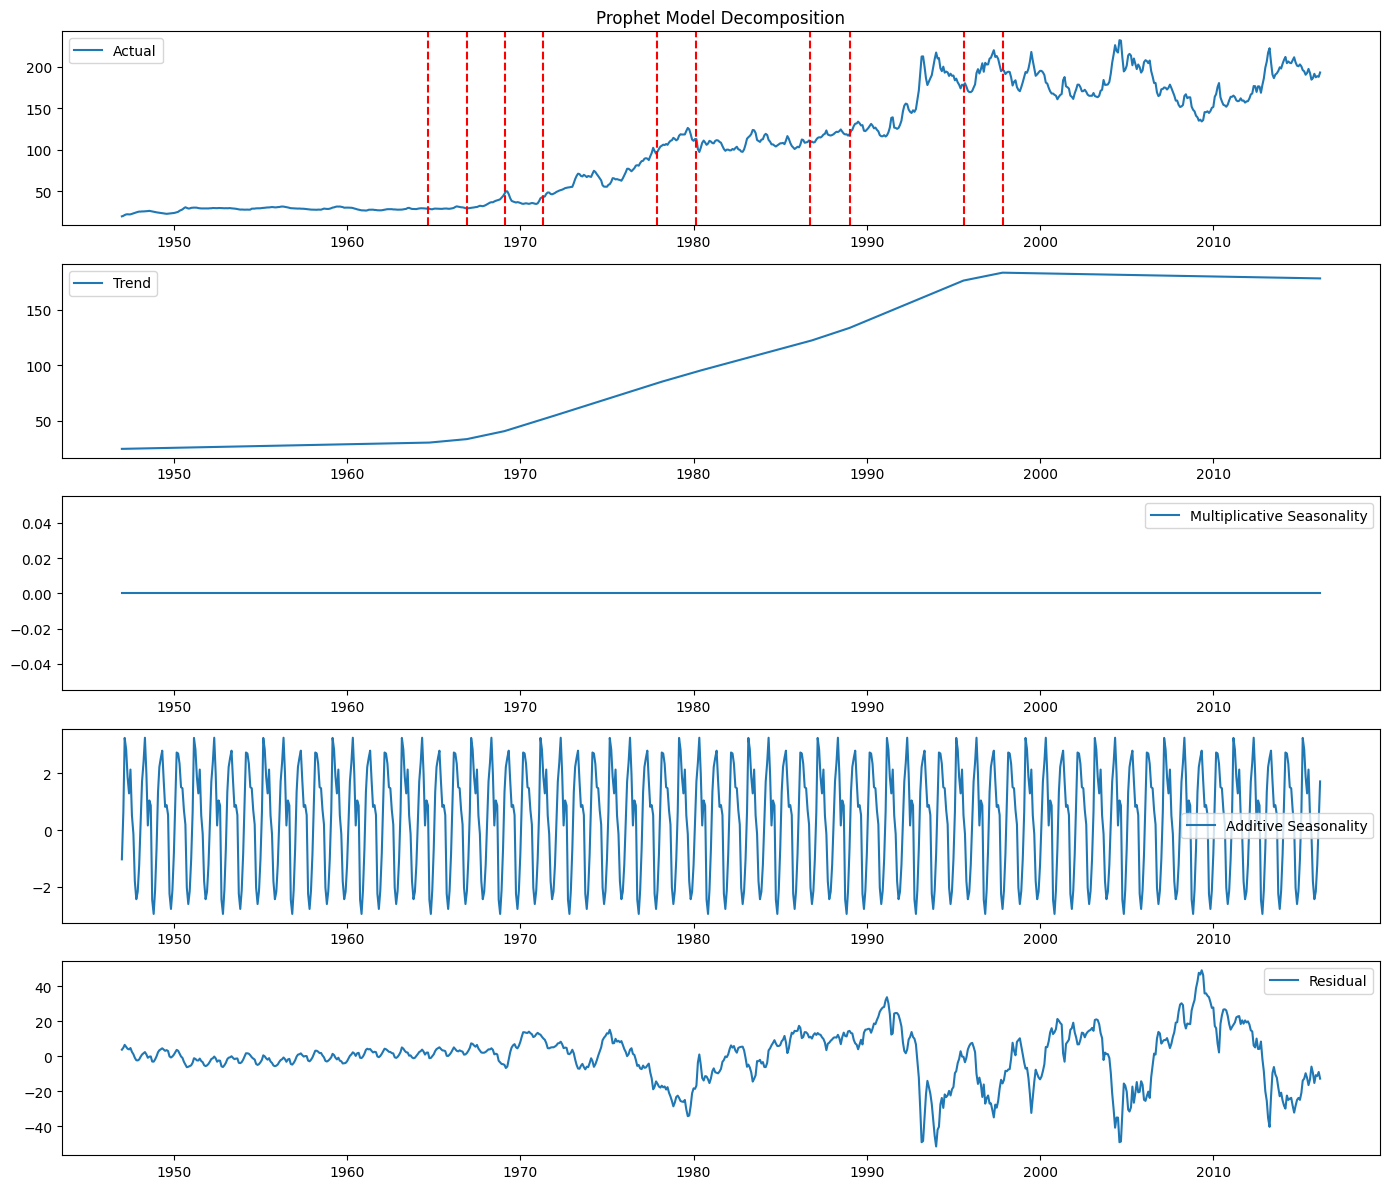

In [67]:
plt.figure(figsize=(14, 12))

plt.subplot(5, 1, 1)
plt.title("Prophet Model Decomposition")

plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual')
add_changepoints_to_plot(plt.gca(), model, forecast, trend=False)
plt.tight_layout()
plt.legend()


plt.subplot(5, 1, 2)
plt.plot(prophet_data['ds'], trend[:len(prophet_data)], label='Trend')
plt.legend()
plt.tight_layout()



plt.subplot(5, 1, 3)
plt.plot(prophet_data['ds'], multiplicative_seasonality[:len(prophet_data)], label='Multiplicative Seasonality')
plt.legend()
plt.tight_layout()



plt.subplot(5, 1, 4)
plt.plot(prophet_data['ds'], additive_seasonality[:len(prophet_data)], label='Additive Seasonality')
plt.legend()
plt.tight_layout()


plt.subplot(5, 1, 5)
plt.plot(prophet_data['ds'], residual, label='Residual')
plt.tight_layout()
plt.legend()



plt.show()

Prophet detected 10 distinct change points, effectively capturing the underlying patterns in the data. 
By fine-tuning the changepoint threshold, we aim to pinpoint significant changes in the data without excessively emphasizing random fluctuations.

#### Hyperparameter Tuning

In [68]:
hyperparameters = [
    {},
    {'n_changepoints': 25},
    {'changepoint_range': 0.5, 'n_changepoints':25},
    {'changepoint_range': 0.5, 'n_changepoints':35},  
    {'changepoint_range': 1, 'n_changepoints':30,'changepoint_prior_scale' : 0.1},
    {'changepoint_range': 0.7, 'n_changepoints':35,'changepoint_prior_scale' : 0.05}]

df = pd.DataFrame(columns=['Model','model_config', 'RMSE', 'MAE', 'MAPE', 'MASE'])

train_prophet = deepcopy(train_data)

for i, model_config in enumerate(hyperparameters):
        
    model = Prophet(**model_config)
    model.fit(prophet_data)
    forecast = model.predict(prophet_data)
        
    act_values = prophet_data['y'].values
    pred_values = forecast['yhat']

    rmse = np.sqrt(mean_squared_error(act_values, pred_values))
    mae = mean_absolute_error(act_values, pred_values)
    mape = np.mean(np.abs((act_values - pred_values) / act_values)) * 100
    mase = mae / np.mean(np.abs(np.diff(prophet_data['y'].values))) 
    
    
    df.loc[len(df)] = [f"Model {i+1}",model_config, rmse, mae, mape, mase]
    
pd.set_option('display.max_colwidth', None)
df

,Model,model_config,RMSE,MAE,MAPE,MASE
0,Model 1,{},14.464597,10.465550,10.204569,4.339298
1,Model 2,{'n_changepoints': 25},14.464597,10.465550,10.204569,4.339298
2,Model 3,"{'changepoint_range': 0.5, 'n_changepoints': 25}",18.767741,12.683061,11.597402,5.258737
3,Model 4,"{'changepoint_range': 0.5, 'n_changepoints': 35}",18.781209,12.723297,11.731496,5.275420
4,Model 5,"{'changepoint_range': 1, 'n_changepoints': 30, 'changepoint_prior_scale': 0.1}",10.927906,7.584322,7.653191,3.144663
5,Model 6,"{'changepoint_range': 0.7, 'n_changepoints': 35, 'changepoint_prior_scale': 0.05}",14.106687,10.169471,9.962518,4.216535


The Prophet Model 5 demonstrates superior performance on the in-sample data.

Config : {'changepoint_range': 1, 'n_changepoints': 30, 'changepoint_prior_scale': 0.1}

Considering that real-world lumber prices typically do not exhibit saturation due to inflation, there is no need to explore logistic regression in this context.

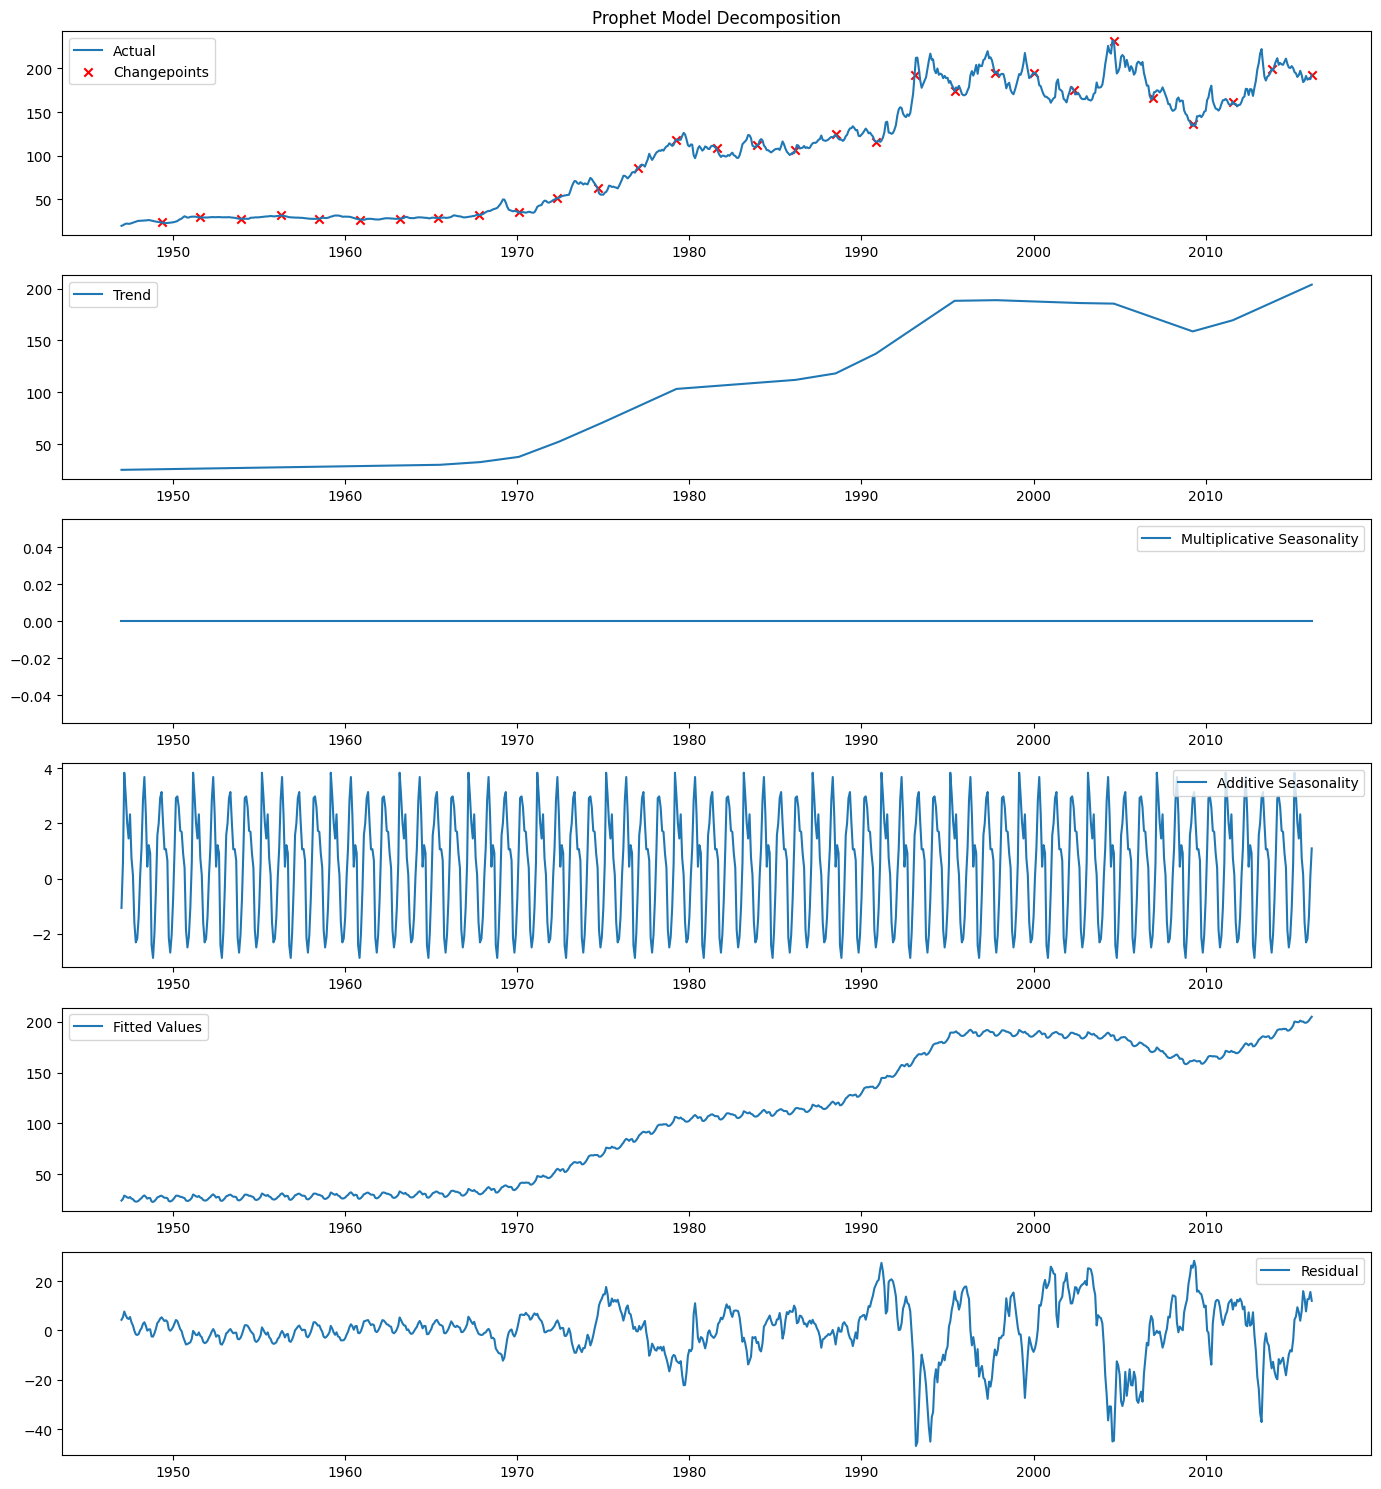

In [69]:
model = Prophet(changepoint_prior_scale=0.1, changepoint_range=1, n_changepoints=30)
model.fit(prophet_data)
forecast = model.predict(prophet_data)

trend = forecast['trend']
multiplicative_seasonality = forecast['multiplicative_terms']
additive_seasonality = forecast['additive_terms']
residual = forecast['yhat'] - prophet_data['y']

plt.figure(figsize=(14, 15))

plt.subplot(6, 1, 1)
plt.title("Prophet Model Decomposition")
plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual')

prophet_data_reset = prophet_data.reset_index()
plt.scatter(model.changepoints, prophet_data_reset.loc[prophet_data_reset['ds'].isin(model.changepoints)]['y'], marker='x', color='red', label='Changepoints')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(prophet_data['ds'], trend[:len(prophet_data)], label='Trend')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(prophet_data['ds'], multiplicative_seasonality[:len(prophet_data)], label='Multiplicative Seasonality')
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(prophet_data['ds'], additive_seasonality[:len(prophet_data)], label='Additive Seasonality')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(prophet_data['ds'], forecast['yhat'], label='Fitted Values')
plt.legend()


plt.subplot(6, 1, 6)
plt.plot(prophet_data['ds'], residual[:len(prophet_data)], label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

## Section 4 - Model Comparison and Validation


In [70]:
jumps = 12 * 7

train_data['id'] = 0

for id, start_index in enumerate(range(0, train_data.shape[0], jumps)):
    end_index = min(start_index + jumps, train_data.shape[0])
    train_data['id'][start_index:end_index] = id + 1

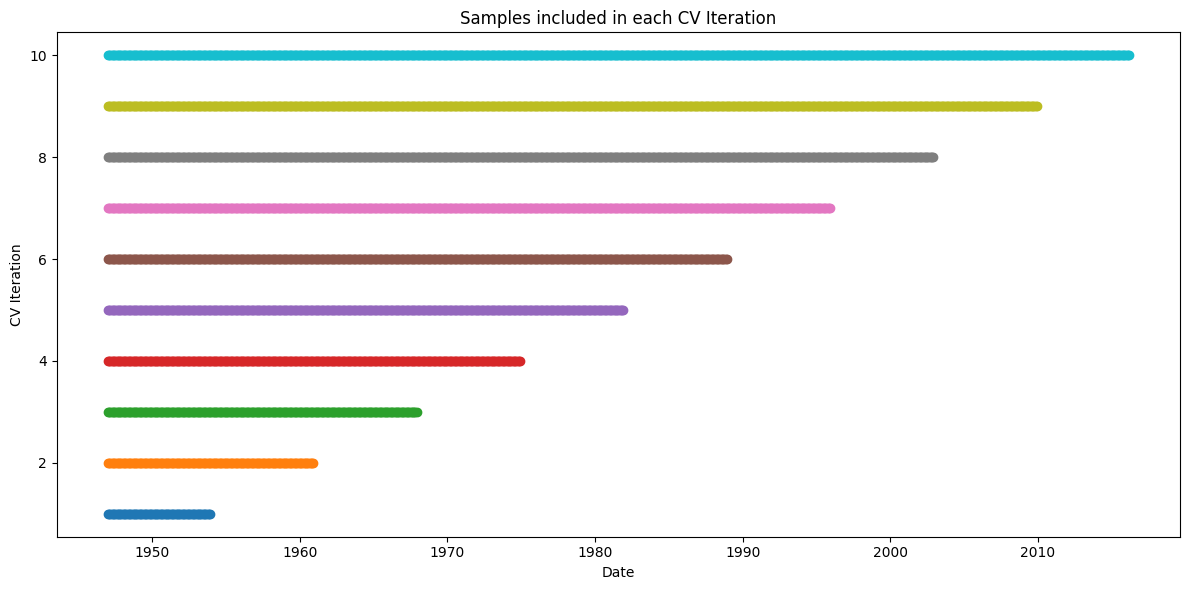

In [71]:
plt.figure(figsize=(12, 6))

for i in train_data['id'].unique():
    
    lst = np.arange(1,i+1)
    X = train_data[train_data['id'].isin(lst)]['date']
    Y = [i] * len(X)
    
    plt.scatter(X, Y, cmap='viridis')


plt.xlabel('Date')
plt.ylabel('CV Iteration')
plt.title('Samples included in each CV Iteration')

plt.tight_layout()
plt.show()


In [72]:
col = 'lumber_price'
forecast_periods = 24

test_sets = dict()
arima_pred = dict()
naive_pred = dict()
prophet_pred = dict()

metrics_df = pd.DataFrame(columns=['CV ID','metric','ARIMA','SNaive_WD','Prophet'])


train = deepcopy(train_data.rename(columns={'date':'ds',
                                           'lumber_price':'y'}))

test  = deepcopy(data.rename(columns={'date':'ds',
                                           'lumber_price':'y'}))

for i, cv_id in enumerate(train['id'].unique()):
    
    ids = np.arange(1,cv_id+1)
    cv_train_data = train[train.id.isin(ids)]
    cv_test_data = test[len(cv_train_data):len(cv_train_data)+forecast_periods]
    
    arima_model = ARIMA(cv_train_data['log_lumber_price'], order=(2,1,0), seasonal_order=(0, 0, 0, 0)).fit()
    arima_forecasted_data = arima_model.get_forecast(steps=forecast_periods)
    arima_forecast = np.exp(arima_forecasted_data.predicted_mean)
    
    prophet_model = Prophet(changepoint_prior_scale=0.1, changepoint_range=1, n_changepoints=30)
    prophet_model.fit(cv_train_data[['ds','y']])
    prophet_forecast = prophet_model.predict(cv_test_data[['ds']])
        
    drift = (cv_train_data['y'][len(cv_train_data)-1] - cv_train_data['y'][0])/(len(cv_train_data)-1)
    lagged_val = cv_train_data['y'][len(cv_train_data)-1]
    naive_forecast = [(lagged_val + (i+1) * drift )for i in range(0, forecast_periods)] + cv_test_data['seasonal']
    
    test_sets[cv_id] = cv_test_data['ds']
    arima_pred[cv_id] = arima_forecast
    naive_pred[cv_id] = naive_forecast
    prophet_pred[cv_id] = prophet_forecast
    
    actual = cv_test_data['y'].values
    
    metrics_df.loc[len(metrics_df)] = [cv_id, "RMSE", 
                                       np.sqrt(mean_squared_error(actual, arima_forecast)),
                                       np.sqrt(mean_squared_error(actual, naive_forecast)),
                                       np.sqrt(mean_squared_error(actual, prophet_forecast['yhat']))]
    
    metrics_df.loc[len(metrics_df)] = [cv_id, "MAE", 
                                       mean_absolute_error(actual, arima_forecast),
                                       mean_absolute_error(actual, naive_forecast),
                                       mean_absolute_error(actual, prophet_forecast['yhat'])]
    
    metrics_df.loc[len(metrics_df)] = [cv_id, "MAPE", 
                                       np.mean(np.abs((actual - arima_forecast) / actual)) * 100,
                                       np.mean(np.abs((actual- naive_forecast) / actual)) * 100,
                                       np.mean(np.abs((actual - prophet_forecast['yhat']) / actual)) * 100]
    
    metrics_df.loc[len(metrics_df)] = [cv_id, "MASE", 
                                       mean_absolute_error(actual, arima_forecast) / mean_absolute_error(actual, naive_forecast),
                                       mean_absolute_error(actual, naive_forecast) / mean_absolute_error(actual, naive_forecast),
                                       mean_absolute_error(actual, prophet_forecast['yhat']) / mean_absolute_error(actual, naive_forecast)]

    
    

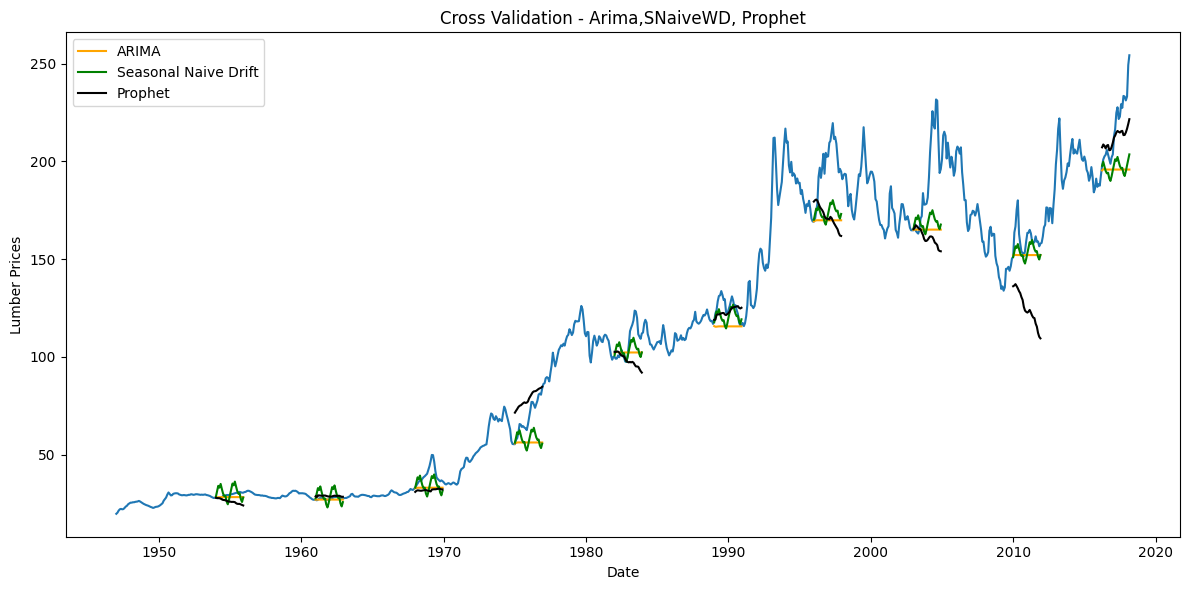

In [73]:
plot_data = data.iloc[:len(train_data)+forecast_periods]

plt.figure(figsize=(12, 6))
plt.plot(plot_data['date'],plot_data['lumber_price'], label = 'Original Time Series')

handles = []
for id in train_data['id'].unique():
    arima_line, = plt.plot(test_sets[id], arima_pred[id], color = 'orange')
    naive_line, = plt.plot(test_sets[id], naive_pred[id], color = 'green')
    prophet_line, = plt.plot(test_sets[id], prophet_pred[id]['yhat'], color = 'black')
    
    handles.extend([arima_line, naive_line, prophet_line])

plt.legend(handles=handles, labels=['ARIMA', 'Seasonal Naive Drift', 'Prophet'])

plt.plot()
plt.xlabel('Date')
plt.ylabel('Lumber Prices')
plt.title("Cross Validation - Arima,SNaiveWD, Prophet")
plt.tight_layout()
plt.show()


After examining the cross-validation visualizations, it is evident that the Seasonal Naive With Drift model outperforms both ARIMA and Prophet. Now, let's assess the comparative performance metrics of these models.

In [74]:
metrics_df

,CV ID,metric,ARIMA,SNaive_WD,Prophet
0,1,RMSE,1.550976,3.771351,3.984371
1,1,MAE,1.337089,3.133760,3.317805
2,1,MAPE,4.450788,10.728902,11.004822
3,1,MASE,0.426672,1.000000,1.058730
4,2,RMSE,0.790373,3.449746,1.315517
5,2,MAE,0.646814,2.843728,1.216344
6,2,MAPE,2.309629,10.284585,4.430680
7,2,MASE,0.227453,1.000000,0.427729
8,3,RMSE,7.968374,6.888402,8.956070
9,3,MAE,6.540155,5.797423,7.718064


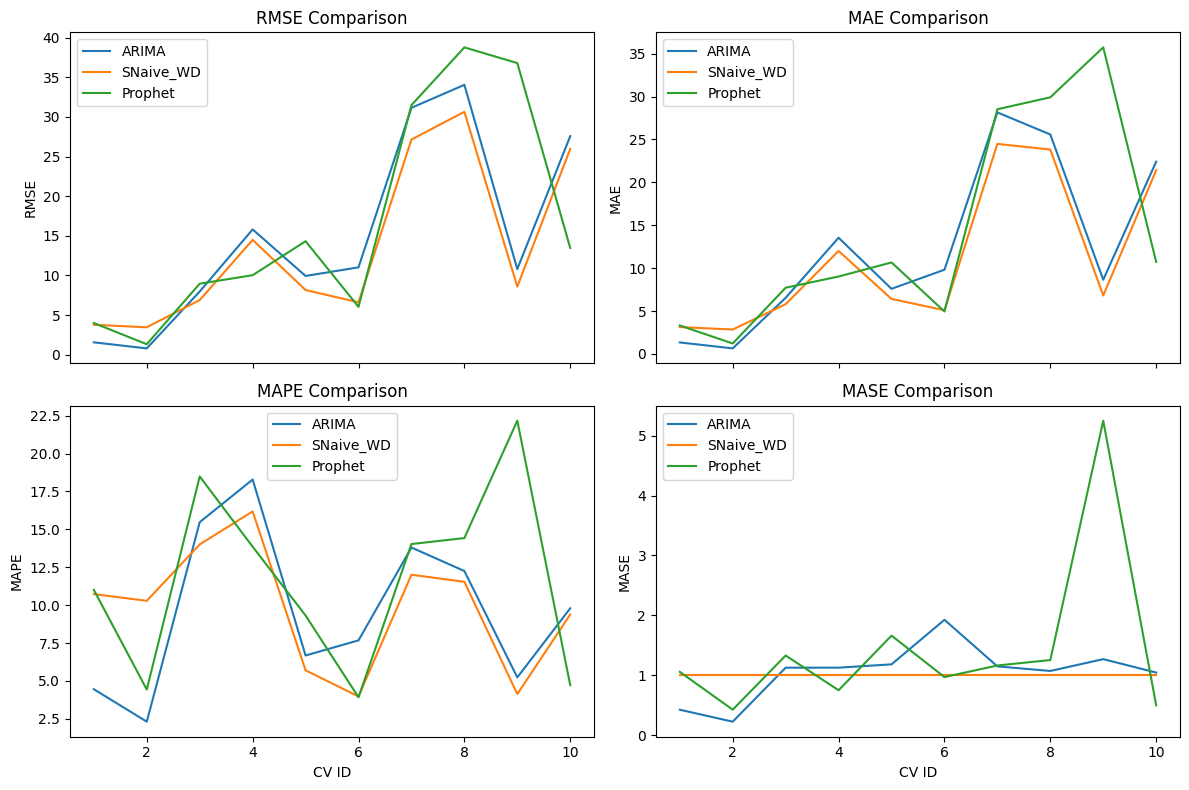

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

metrics = ['RMSE', 'MAE', 'MAPE', 'MASE']
models = ['ARIMA', 'SNaive_WD', 'Prophet']

for i, metric in enumerate(metrics):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    for model in models:
        df_model = metrics_df[metrics_df['metric'] == metric]
        sns.lineplot(x='CV ID', y=model, data=df_model, label=model, ax=ax)

    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_xlabel('CV ID')
    ax.legend()

plt.tight_layout()
plt.show()


In [76]:
metrics_df.groupby('metric').agg({'ARIMA':'mean', 'SNaive_WD':'mean', 'Prophet':'mean'})

,ARIMA,SNaive_WD,Prophet
metric,,,
MAE,12.424793,11.179076,14.175766
MAPE,9.595360,9.793640,11.635970
MASE,1.056245,1.000000,1.437483
RMSE,15.062820,13.568223,16.513747


Overall, Seasonal Naive With Drift consistently outperforms other models, exhibiting superior performance across diverse metrics, notably achieving MAE, MAPE, RMSE, and MASE values of 1 and higher, while ARIMA and Prophet fall short in comparison.

Now, we'll proceed to apply the Seasonal Naive With Drift model to the test dataset.

#### Forecasting our Sesonal Naive With Drift Model on Test Data

In [77]:
drift = (train_data['lumber_price'][len(train_data)-1] - train_data['lumber_price'][0])/(len(train_data)-1)
lagged_val = train_data['lumber_price'][len(train_data)-1]
naive_forecast = [(lagged_val + (i+1) * drift )for i in range(0, len(test_data))] + test_data['seasonal']

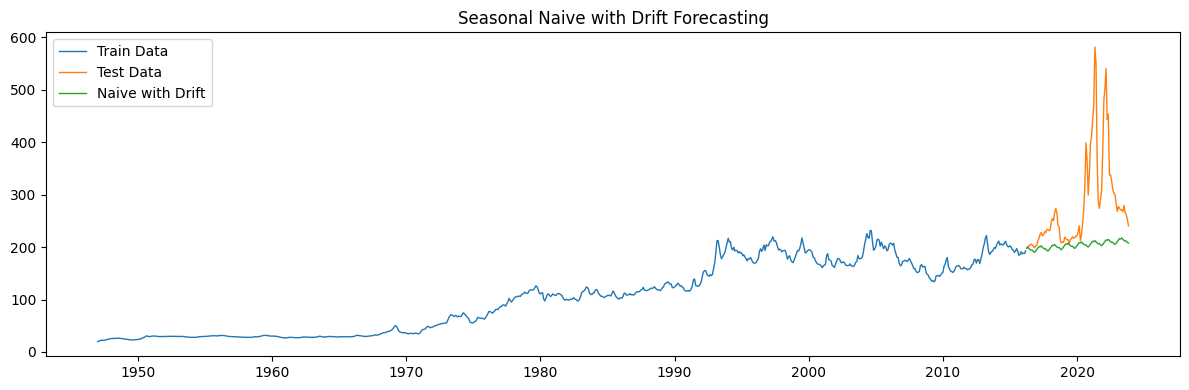

In [78]:
plt.figure(figsize=(12, 4))

plt.plot(train_data['date'], train_data['lumber_price'], label='Train Data', linewidth=1)
plt.plot(test_data['date'], test_data['lumber_price'], label='Test Data', linewidth=1)
plt.plot(test_data['date'],naive_forecast , label='Naive with Drift', linewidth=1)

plt.legend()
plt.title("Seasonal Naive with Drift Forecasting")
plt.tight_layout()
plt.show()

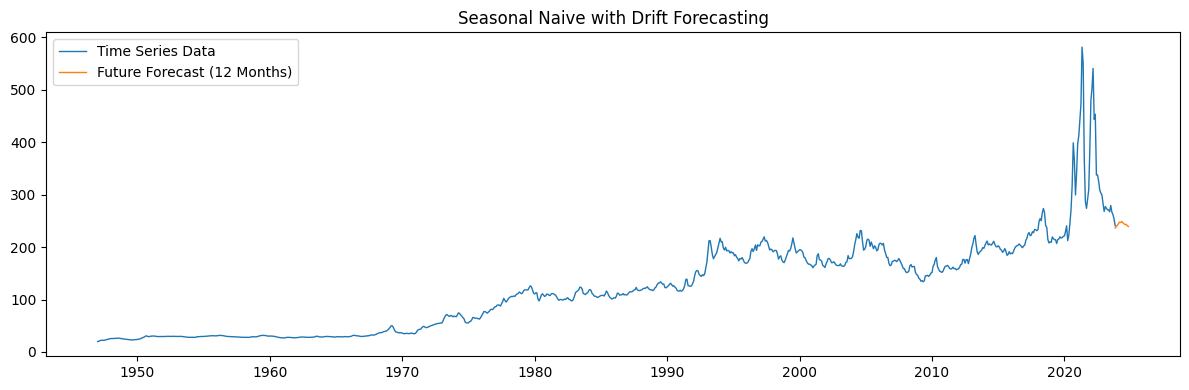

In [79]:
future_dates = pd.date_range(data['date'].max(), periods=13, freq='MS')
future_dates_df = pd.DataFrame({'ds': future_dates})
future_dates_df['seasonal'] = future_dates_df['ds'].dt.month.map(seasonal_mean)

drift = (data['lumber_price'][len(data)-1] - data['lumber_price'][0])/(len(data)-1)
lagged_val = data['lumber_price'][len(data)-1]
snaive_forecast = [(lagged_val + (i+1) * drift )for i in range(0, 13)] + future_dates_df['seasonal']

plt.figure(figsize=(12, 4))

plt.plot(data['date'], data['lumber_price'], label='Time Series Data', linewidth=1)
plt.plot(future_dates_df['ds'], snaive_forecast , label='Future Forecast (12 Months)', linewidth=1)

plt.legend()
plt.title("Seasonal Naive with Drift Forecasting")
plt.tight_layout()
plt.show()

Snaive with Drift forecast shows declining lumber prices values for the next year, based on seasonal data and assuming trends continue. Consider potential limitations of forecasts, including unexpected events and inherent model inaccuracies. We can use this forecasting as a directional guide, but not a guaranteed prediction.